In [1]:
import pandas as pd 
import numpy as np
import os 
import json
from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.preprocessing import LabelEncoder,scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

import re
import nltk
from nltk.corpus import stopwords


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, Dropout,BatchNormalization, GlobalMaxPooling1D,MaxPooling1D,LSTM
from keras.metrics import categorical_accuracy
from keras.callbacks import  EarlyStopping


Using TensorFlow backend.


In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('&lt;|br&gt;|b&gt;|ul&gt;|li&gt;')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
RemoveLastSpace = re.compile(' $')

def clean_text_category(text):
    text = RemoveLastSpace.sub('',text)
    return text
    

In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=30):
            dropCategory.append(key)
    return dropCategory

In [8]:
df = pd.read_csv('../../example/amazon_co-ecommerce_sample.csv')

In [9]:
df = df[pd.notnull(df['amazon_category_and_sub_category'])]
df = df[pd.notnull(df['description'])]
df = df[pd.notnull(df['uniq_id'])]
category = []
subcategory = []
sub2category = []
for ele in df['amazon_category_and_sub_category'].apply(lambda x: str(x).split('>')):
    category.append(ele[0])
    if(len(ele)>2):
        subcategory.append(ele[1])
        sub2category.append(ele[2])
    elif(len(ele)>1):
        subcategory.append(ele[1])
        sub2category.append(np.NaN)
    else:
        subcategory.append(np.NaN)
        sub2category.append(np.NaN)

data= {'uniq_id':df['uniq_id'], 'product_name':df['product_name'],'category_main':category,'category_sub1':subcategory,'description':df['description']}
df = pd.DataFrame(data)
df['description'] = df['description'].apply(clean_text)
df.category_main = df['category_main'].apply(clean_text_category)
df.category_sub1 = df['category_sub1'].apply(clean_text_category)

df = df[pd.notnull(df['category_main'])]
df = df[pd.notnull(df['category_sub1'])]


In [10]:
dropCategoryCode  = classNumberThreshold(df.category_main.value_counts())
dropSubCategoryCode  = classNumberThreshold(df.category_sub1.value_counts())

for i in dropCategoryCode:
    df = df[df.category_main!=i]
    
for i in dropSubCategoryCode:
    df = df[df.category_sub1!=i]



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8189 entries, 0 to 9998
Data columns (total 5 columns):
uniq_id          8189 non-null object
product_name     8189 non-null object
category_main    8189 non-null object
category_sub1    8189 non-null object
description      8189 non-null object
dtypes: object(5)
memory usage: 383.9+ KB


In [12]:
embedding_dim = 300 # We use 100 dimensional glove vectors
glove_dir = '../../glove.6B' # This is the folder with the dataset
embeddings_index = {} # We create a dictionary of word -> embedding
with open(os.path.join(glove_dir, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary
    print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [13]:
le = LabelEncoder()
le.fit(df.category_main)
target = le.classes_
labels = le.transform(df.category_main)

le.fit(df.category_sub1.apply(str))
subtarget = le.classes_
sublabels = le.transform(df['category_sub1'])

In [14]:
X_train, X_test, y_train_info, y_test_info = train_test_split(df.description, pd.DataFrame({'index':df.index, 'label':labels}), 
                                                    test_size=0.1, random_state = 27)

In [15]:
y_train = y_train_info.label
y_test = y_test_info.label


In [16]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.description)
vocab_size = len(tfidfconverter.get_feature_names())


In [17]:
def tokenizer_and_pad_sequence (Xtrain,Xtest,vocab_size,embeddings_index):
    tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
    tokenizer.fit_on_texts(Xtrain)
    
    sequences = tokenizer.texts_to_sequences(Xtrain)
    sequences_test = tokenizer.texts_to_sequences(Xtest)
    
    trainlengths = [len(ele) for ele in sequences]
    testlengths = [len(ele) for ele in sequences_test]
    max_length = min(max(trainlengths),max(testlengths))
    
    
    
    word_index = tokenizer.word_index
    embedding_dim = 300
    nb_words = min(vocab_size, len(word_index)) # How many words are there actually
    embedding_matrix = np.zeros((nb_words, embedding_dim))
    # The vectors need to be in the same position as their index. 
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    # Loop over all words in the word index
    for word, i in word_index.items():
        # If we are above the amount of words we want to use we do nothing
        if i >= vocab_size: 
            continue
        # Get the embedding vector for the word
        embedding_vector = embeddings_index.get(word)
        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return sequences,sequences_test,max_length, embedding_matrix

def model_settings(length,vocabSize,embeddingMatrix,outputnum):
        embedding_dim = 300
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=length, weights = [embedding_matrix], 
                                trainable = False))
        model.add(Conv1D(200,3,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(GlobalMaxPooling1D())
        model.add(BatchNormalization())
        # We add a vanilla hidden layer:
        model.add(Dense(250))
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
        return model
def model_settings2(length,vocabSize,embeddingMatrix,outputnum):
        embedding_dim = 300
        model = Sequential()
        model.add(Embedding(vocabSize, embedding_dim, input_length=length, weights = [embeddingMatrix], 
                                trainable = False))
        model.add(Dropout(0.25))
        model.add(Conv1D(128,5,padding='valid',activation='relu',strides=1))        
        # we use max pooling:
        model.add(MaxPooling1D(4))
        model.add(BatchNormalization())
        model.add(LSTM(70))
        model.add(Dropout(0.2))
        model.add(Dense(outputnum, activation='softmax'))
        model.summary()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
        return model

In [18]:
categoricalLabel = to_categorical(y_train)
categoricalTestLabel = to_categorical(y_test)

EPOCHS = 10
BATCH_SIZE = 100

#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)


sequences,sequences_test,max_length, embedding_matrix =  tokenizer_and_pad_sequence(X_train,X_test, vocab_size, embeddings_index)

Scores = []
Models = []
Scores2 = []
Models2 = []
Scores3 = []
Models3 = []
Lengths = [ele for ele in range(50, max_length, 100)]
for ele in range(50, max_length, 100):
    
    train = pad_sequences(sequences,maxlen= ele)
    test = pad_sequences(sequences_test,maxlen = ele)
    
    model = model_settings(ele, vocab_size, embedding_matrix, len(np.unique(y_train)))
    model2 = model_settings2(ele, vocab_size, embedding_matrix, len(np.unique(y_train)))
    model.fit(train, categoricalLabel, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],  
                   verbose=1, validation_split=0.1)
    model2.fit(train, categoricalLabel, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],  
                   verbose=1, validation_split=0.1)
    
    loss, score = model.evaluate(test, categoricalTestLabel, batch_size=BATCH_SIZE)
    loss2, score2 = model2.evaluate(test, categoricalTestLabel, batch_size=BATCH_SIZE)

    Scores.append(score)
    Models.append(model)
    Scores2.append(score2)
    Models2.append(model2)    
    
bestModelIndex = np.argmax(Scores)
bestLength = Lengths[bestModelIndex]
bestModel = Models[bestModelIndex]

bestModelIndex2 = np.argmax(Scores2)
bestLength2 = Lengths[bestModelIndex2]
bestModel2 = Models2[bestModelIndex2]


# save the model to disk
filename = 'Amazon/'+str(bestLength)+'BestCNNs.sav'
joblib.dump(bestModel, filename)

ValueError: attempt to get argmax of an empty sequence

In [15]:
filename2 = 'Amazon/'+str(bestLength2)+'BestLayerCNNswithLSTM.sav'
joblib.dump(bestModel2, filename2)

['Amazon/150BestLayerCNNswithLSTM.sav']

In [16]:
print("CNNs: "+ str(max(Scores)))
print("CNNs+LSTM: "+ str(max(Scores2)))

CNNs: 0.7875457751008618
CNNs+LSTM: 0.733821741463355


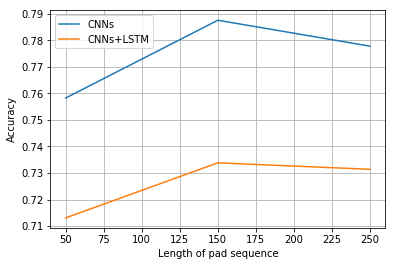

In [17]:
fig,ax  = plt.subplots()
ax.plot(Lengths,Scores,label="CNNs")
ax.plot(Lengths,Scores2,label="CNNs+LSTM")

ax.set_xlabel("Length of pad sequence")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.savefig("Amazon/CNNsbestsequenceLength.png")

In [18]:
test = pad_sequences(sequences_test,maxlen = bestLength)
yConfidence = bestModel.predict(test)
yPred = [ np.argmax(ele) for ele in yConfidence ]

In [19]:
totalConfidenceSize = yConfidence.shape[0]*yConfidence.shape[1]
Confidence1DArr = yConfidence.reshape(totalConfidenceSize,1)
Max = ceil(max(Confidence1DArr)[0])
Min = floor(min(Confidence1DArr)[0])
NormalisedConfid = [round((max(ele)-Min)/(Max-Min),2) for ele in yConfidence]
productID = [ df[df.index==ele]['uniq_id'].values[0] for ele in y_test_info['index'] ]
ProductDescription =[ df[df.index==ele]['description'].values[0] for ele in y_test_info['index'] ]
CNNResult = pd.DataFrame({'id':productID,'description':ProductDescription,
                         'trueClass': y_test,'trueClassNaem':target[y_test] ,
                         'predictClass':yPred,'predictClassName':target[yPred],
                         'Confidence':NormalisedConfid})
CNNResult.to_csv("Amazon/CNNResults.csv",index=False,compression=None)

In [20]:
def draw_confidenceReport(data):
    num = [ ele*0.01 for ele in range(20,81,2)]
    totalitems = []
    correct = []
    incorrect = []
    for ele in num:
        Threshold = data[data['Confidence']>ele]
        correct.append(len(Threshold[Threshold['trueClass']==Threshold['predictClass']].index))
        incorrect.append(len(Threshold[Threshold['trueClass']!=Threshold['predictClass']].index))
        totalitems.append(len(Threshold.index))
    
    ClassfiedProportion = [ ele/len(data.index) for ele in totalitems]
    
    Acc =[]
    for ele in zip(correct,totalitems):
        if (ele[1]==0):
            Acc.append(0)
        else:
            Acc.append(ele[0]/ele[1])

    fig,ax  = plt.subplots()
    
    color = 'tab:blue'
    ax.scatter(num,ClassfiedProportion,label="Proportion classified",color=color)
    ax.set_xlabel("Confidence Score")
    ax.set_ylabel("Proportion classified", color=color)
    ax.xaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.scatter(num,Acc,label="Accuracy", color=color)
    ax2.set_ylabel("Accuracy", color=color)
    ax2.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax2.tick_params(axis='y', labelcolor=color)

    ax.grid()
    fig.savefig("Amazon/ConfidenceScoreReportCNN.png")

In [21]:
print(classification_report(y_test, yPred,target_names=target))
with open('Amazon/CNNReport.txt', 'w') as file:
    file.write(classification_report(y_test, yPred,target_names=target))

                           precision    recall  f1-score   support

            Arts & Crafts       0.79      0.87      0.83        61
      Baby & Toddler Toys       0.50      0.25      0.33         4
      Characters & Brands       0.64      0.70      0.67        83
  Die-Cast & Toy Vehicles       0.81      0.89      0.85       108
      Dolls & Accessories       0.80      0.86      0.83        37
              Fancy Dress       0.74      0.91      0.82        56
       Figures & Playsets       0.70      0.75      0.73       106
                    Games       0.89      0.83      0.86        93
                  Hobbies       0.85      0.70      0.77       148
        Jigsaws & Puzzles       0.77      0.56      0.65        18
           Party Supplies       0.84      0.84      0.84        50
             Pretend Play       1.00      0.20      0.33         5
Puppets & Puppet Theatres       0.95      0.95      0.95        22
    Sports Toys & Outdoor       0.80      0.71      0.75     

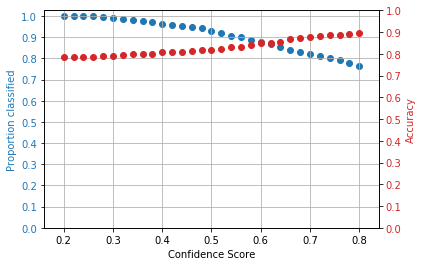

In [22]:
draw_confidenceReport(CNNResult)

In [23]:
cm = confusion_matrix(y_test, yPred)

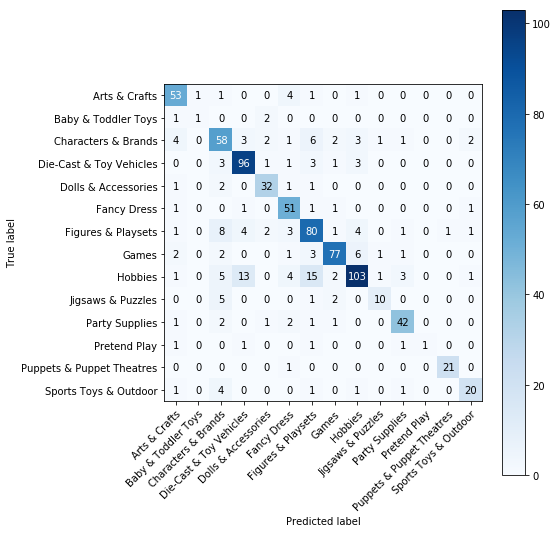

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
im =ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = target[unique_labels(y_test, yPred)]
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,ylabel='True label',xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
fig.savefig("Amazon/CNNConfusionMatrix.png")